In [1]:
# LOAD PACKAGES
import warnings
import torch
from gpytorch.distributions import base_distributions
from gpytorch.functions import log_normal_cdf
from gpytorch.likelihoods.likelihood import _OneDimensionalLikelihood

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
import gpytorch
import time as time

/Users/yahoo/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
# implement BinomialLikelihood
class BinomialLikelihood(_OneDimensionalLikelihood):
    r"""
    Implements the Binomial likelihood for count data y between 1 and m. 
    The Binomial distribution is parameterized by :math:`m > 0`. 
    We can write the likelihood as:

    .. math::
        \begin{equation*}
            p(Y=y|f,m)=\phi(f)^y(1-\phi(f))^{(m-y)}
        \end{equation*}
    """

    def __init__(self, n_trials):
        super().__init__()
        self.n_trials = n_trials

    def forward(self, function_samples, **kwargs):
        output_probs = base_distributions.Normal(0, 1).cdf(function_samples)
        return base_distributions.Binomial(total_count=self.n_trials, probs=output_probs)

    def log_marginal(self, observations, function_dist, *args, **kwargs):
        marginal = self.marginal(function_dist, *args, **kwargs)
        return marginal.log_prob(observations)

    def marginal(self, function_dist, **kwargs):
        mean = function_dist.mean
        var = function_dist.variance
        link = mean.div(torch.sqrt(1 + var))
        output_probs = base_distributions.Normal(0, 1).cdf(link)
        return base_distributions.Binomial(total_count=self.num_data, probs=output_probs)

    def expected_log_prob(self, observations, function_dist, *params, **kwargs):
        if torch.any(torch.logical_or(observations.le(-1), observations.ge(self.n_trials+1))):
            # Remove after 1.0
            warnings.warn(
                "BinomialLikelihood.expected_log_prob expects observations with labels in [0, m]. "
                "Observations <0 or >m are not allowed.",
                DeprecationWarning,
            )
        else:
            for i in range(observations.size(0)):
                observations[i] = torch.clamp(observations[i],0,self.n_trials[i])

        # custom function here so we can use log_normal_cdf rather than Normal.cdf
        # this is going to be less prone to overflow errors
        log_prob_lambda = lambda function_samples: self.n_trials*log_normal_cdf(-function_samples) + \
                observations.mul(log_normal_cdf(function_samples)-log_normal_cdf(-function_samples))
        log_prob = self.quadrature(log_prob_lambda, function_dist)
        return log_prob

In [3]:
from typing import Optional
from gpytorch.lazy import DiagLazyTensor, InterpolatedLazyTensor, PsdSumLazyTensor, RootLazyTensor
from gpytorch.constraints import Interval, Positive
from gpytorch.priors import Prior
from gpytorch.kernels import Kernel

class QuadraticKernel(Kernel):
    r"""
    Computes a covariance matrix based on the Quadratic kernel
    between inputs :math:`\mathbf{x_1}` and :math:`\mathbf{x_2}`:

    .. math::
        \begin{equation*}
            k_\text{Quad}(\mathbf{x_1}, \mathbf{x_2}) = \mathbf{x_1}^\top
            (\mathbf{A}^\top\mathbf{A}+\mathbf{v}) \mathbf{x_2}.
        \end{equation*}

    where

    * :math:`\mathbf{A}` is a low-rank variance parameter.

    Args:
        num_dims (int):
            Total number of dimensions.
        rank (int):
        var_prior (:class:`gpytorch.priors.Prior`):
            Prior over the variance parameter (default `None`).
        var_constraint (Constraint, optional):
            Constraint to place on var parameter. Default: `Positive`.
    """

    def __init__(
        self,
        rank: int,
        num_dims: int, 
        var_prior: Optional[Prior] = None,
        var_constraint: Optional[Interval] = None,
        **kwargs,
    ):
        if rank > num_dims:
            raise RuntimeError("Cannot create a task covariance matrix larger than the number of dims")
        
        super().__init__(**kwargs)
        if var_constraint is None:
            var_constraint = Positive()

        self.register_parameter(
            name="covar_factor", parameter=torch.nn.Parameter(torch.randn(*self.batch_shape, num_dims, rank))
        )

        self.register_parameter(name="raw_var", parameter=torch.nn.Parameter(torch.randn(*self.batch_shape, num_dims)))
        
        if var_prior is not None:
            if not isinstance(var_prior, Prior):
                raise TypeError("Expected gpytorch.priors.Prior but got " + type(var_prior).__name__)
            self.register_prior("QualdraticKernelPrior", var_prior, lambda m: m._eval_covar_matrix())

        self.register_constraint("raw_var", var_constraint)

    @property
    def var(self):
        return self.raw_var_constraint.transform(self.raw_var)

    @var.setter
    def var(self, value):
        self._set_var(value)

    def _set_var(self, value):
        self.initialize(raw_var=self.raw_var_constraint.inverse_transform(value))

    def _eval_covar_matrix(self):
        cf = self.covar_factor
        return cf @ cf.transpose(-1, -2) + torch.diag_embed(self.var)

    @property
    def covar_matrix(self):
        var = self.var
        res = PsdSumLazyTensor(RootLazyTensor(self.covar_factor), DiagLazyTensor(var))
        return res
    
    def forward(
        self,
        x1: torch.Tensor,
        x2: torch.Tensor,
        last_dim_is_batch: False,
        **params,
    ):
        covar_matrix = self._eval_covar_matrix()
        if last_dim_is_batch:
            x1 = x1.transpose(-1, -2).unsqueeze(-1)
            x2 = x2.transpose(-1, -2).unsqueeze(-1)

        res = torch.matmul(x1, covar_matrix)
        res = torch.matmul(res,  x2.transpose(-2, -1))
        return res


In [27]:
# implement GP class
class BinomialGPModel(gpytorch.models.ApproximateGP):
    '''
        Latent Gaussian process model
        x: 8x1 lat,long, male, female, white, black, other, year
        continuous: [0,1,7] (lat, long, year)
        binary: [2,3,4,5,6] (male, female, white, black, other)
        kronecker product kernel: K(lat,long) * K(year) * K(male, female, white, black, other)
        K(lat,long): RBF
        K(year): RBF
        K(male, female, white, black, other): 5x5 diagonal matrix (no interaction)/
                                              5x5 look up table (with interaction)
    '''
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = VariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(BinomialGPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.LinearMean(input_size=train_x.size(1))
        # separate kernel for covariate, geospatial and time confounding
        self.covar_module_geo = gpytorch.kernels.RBFKernel(active_dims=[0,1], ard_num_dims=2)
        self.covar_module_time = gpytorch.kernels.RBFKernel(active_dims=[7])
        self.covar_module_binary = QuadraticKernel(rank=2, num_dims=5)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module_geo(x) * self.covar_module_time(x) * self.covar_module_binary(x[:,2:7])
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    

In [7]:
# implement GP class
class BinomialGPModel2(gpytorch.models.ApproximateGP):
    '''
        Latent Gaussian process model
        x: 8x1 lat,long, male, female, white, black, other, year
        continuous: [0,1,7] (lat, long, year)
        binary: [2,3,4,5,6] (male, female, white, black, other)
        additive kronecker product kernel: K(lat,long) * K(year) * 
                [K(male, female) + K(white, black, other)]
        K(lat,long): RBF
        K(year): RBF
        K(male, female), K(white, black, other): diagonal matrix
    '''
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = VariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(BinomialGPModel2, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.LinearMean(input_size=train_x.size(1))
        # separate kernel for covariate, geospatial and time confounding
        self.covar_module_geo = gpytorch.kernels.RBFKernel(active_dims=[0,1], ard_num_dims=2)
        self.covar_module_time = gpytorch.kernels.RBFKernel(active_dims=[7])
        self.covar_module_gender = QuadraticKernel(rank=2, num_dims=2)
        self.covar_module_race = QuadraticKernel(rank=3, num_dims=3)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module_gender(x[:,2:4]) + self.covar_module_race(x[:,4:7])
        covar_x = self.covar_module_geo(x) * self.covar_module_time(x) * covar_x
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    

In [5]:
def transform_data(data):
    n = data.shape[0]
    x = np.zeros((n,8))
    y = np.zeros((n,))
    theta = np.zeros((n,))
    N = np.zeros((n,))
    x[:,0] = data["lat"].to_numpy()
    x[:,1] = data["lon"].to_numpy()
    x[:,2] = (data["gender"].to_numpy()=="Male")
    x[:,3] = (data["gender"].to_numpy()=="Female")
    x[:,4] = (data["race"].to_numpy()=="White")
    x[:,5] = (data["race"].to_numpy()=="Black")
    x[:,6] = (data["race"].to_numpy()=="Other")
    x[:,7] = data["year"].to_numpy()
    latent_pref = data["latent_group_pref"].to_numpy()
    y = data["Y"].to_numpy()
    N = data["n"].to_numpy()

    return (
        torch.from_numpy(x).double(),
        torch.from_numpy(y).double(),
        torch.from_numpy(N).double(),
        torch.from_numpy(latent_pref).double()
    )


In [8]:
torch.manual_seed(0)

def standardize_features(df, columns):
    for col in columns:
        mean_val = df[col].mean()
        std_val = df[col].std()
        df[col] = (df[col] - mean_val) / (std_val + 1e-8)
    return df

# load data
train_data = pd.read_csv("./sample_agg_train.csv", index_col=0)
test_data = pd.read_csv("./sample_agg_test.csv", index_col=0)

# uncomment below for faster debugging
# train_data = train_data.sample(n=500)
# test_data = test_data.sample(n=100)

# standardize lat, lon, and year 
cols_to_scale = ["lat", "lon", "year"]
train_data = standardize_features(train_data, cols_to_scale)
test_data = standardize_features(test_data, cols_to_scale)

# transform data
train_x, train_y, train_N, train_pref = transform_data(train_data)
test_x, test_y, test_N, test_pref = transform_data(test_data)

# initialize likelihood and model
likelihood = BinomialLikelihood(n_trials=train_N)
model = BinomialGPModel2(train_x=train_x).double()

training_iterations = 200

# find optimal model hyperparameters
model.train()
likelihood.train()

# use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05) 

mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

start = time.time()

for i in range(training_iterations):
    # zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # get predictive output
    output = model(train_x)
    # calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

end = time.time()

/Users/yahoo/anaconda3/lib/python3.7/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Iter 1/200 - Loss: 145.433
Iter 2/200 - Loss: 1702.869
Iter 3/200 - Loss: 390.705
Iter 4/200 - Loss: 572.706
Iter 5/200 - Loss: 700.854
Iter 6/200 - Loss: 504.867
Iter 7/200 - Loss: 291.144
Iter 8/200 - Loss: 194.947
Iter 9/200 - Loss: 184.231
Iter 10/200 - Loss: 191.642
Iter 11/200 - Loss: 182.856
Iter 12/200 - Loss: 159.036
Iter 13/200 - Loss: 133.221
Iter 14/200 - Loss: 113.741
Iter 15/200 - Loss: 101.138
Iter 16/200 - Loss: 92.204
Iter 17/200 - Loss: 84.235
Iter 18/200 - Loss: 76.548
Iter 19/200 - Loss: 69.574
Iter 20/200 - Loss: 63.572
Iter 21/200 - Loss: 58.324
Iter 22/200 - Loss: 53.535
Iter 23/200 - Loss: 49.154
Iter 24/200 - Loss: 45.312
Iter 25/200 - Loss: 42.101
Iter 26/200 - Loss: 39.459
Iter 27/200 - Loss: 37.225
Iter 28/200 - Loss: 35.255
Iter 29/200 - Loss: 33.470
Iter 30/200 - Loss: 31.836
Iter 31/200 - Loss: 30.327
Iter 32/200 - Loss: 28.931
Iter 33/200 - Loss: 27.649
Iter 34/200 - Loss: 26.482
Iter 35/200 - Loss: 25.435
Iter 36/200 - Loss: 24.523
Iter 37/200 - Loss: 2

In [12]:
print(model.covar_module_geo.lengthscale)

tensor([[1.1835, 1.1776]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)


In [13]:
print("trained for {:d} min {:d} sec for {:d} iterations".format(int(end-start)//60,int(end-start)%60,training_iterations))

trained for 243 min 59 sec for 200 iterations


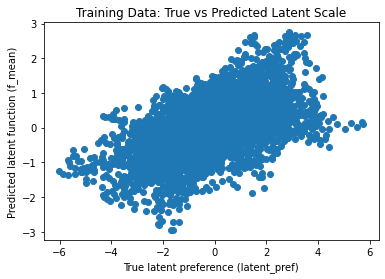

In [14]:
model.eval()
likelihood.eval()

with torch.no_grad():
    f_pred = model(train_x)
    # mean of the latent function f(x)
    mu = f_pred.mean.numpy()

plt.scatter(train_pref.numpy(), mu)  
plt.xlabel("True latent preference (latent_pref)")
plt.ylabel("Predicted latent function (f_mean)")
plt.title("Training Data: True vs Predicted Latent Scale")
plt.show()

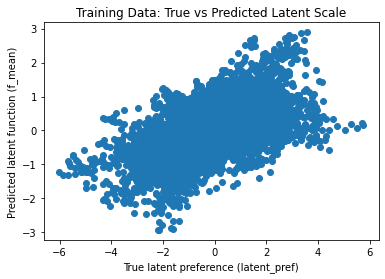

In [15]:
model.eval()
likelihood.eval()

with torch.no_grad():
    f_pred2 = model(test_x)
    mu2 = f_pred2.mean.numpy()

plt.scatter(test_pref.numpy(), mu2)  
plt.xlabel("True latent preference (latent_pref)")
plt.ylabel("Predicted latent function (f_mean)")
plt.title("Training Data: True vs Predicted Latent Scale")
plt.show()

In [16]:
results = pd.DataFrame({
    "true_pref": train_pref.numpy(), 
    "est_mean": mu  
})

results["est_std"] = np.sqrt(f_pred.variance.numpy())  

lower = results['est_mean'] - 2*results['est_std']
upper = results['est_mean'] + 2*results['est_std']

coverage = np.mean(np.logical_and(lower >= results["true_pref"], upper <= results["true_pref"]))
rmse = np.sqrt(np.mean((results["true_pref"] - results["est_mean"]) ** 2))
correlation = np.corrcoef(results["true_pref"], results["est_mean"])[0, 1]

print("Train avg 95% Coverage: {:.3f}".format(coverage))
print("Train avg RMSE: {:.3f}".format(rmse))
print("Train correlation: {:.3f}".format(correlation))

Train avg 95% Coverage: 0.000
Train avg RMSE: 1.310
Train correlation: 0.583


In [17]:
results2 = pd.DataFrame({
    "true_pref": test_pref.numpy(), 
    "est_mean": mu2  
})

results2["est_std"] = np.sqrt(f_pred2.variance.numpy())  

lower = results2['est_mean'] - 2*results2['est_std']
upper = results2['est_mean'] + 2*results2['est_std']

coverage = np.mean(np.logical_and(lower >= results2["true_pref"], upper <= results2["true_pref"]))
rmse = np.sqrt(np.mean((results2["true_pref"] - results2["est_mean"]) ** 2))
correlation = np.corrcoef(results2["true_pref"], results2["est_mean"])[0, 1]

print("Train avg 95% Coverage: {:.3f}".format(coverage))
print("Train avg RMSE: {:.3f}".format(rmse))
print("Train correlation: {:.3f}".format(correlation))

Train avg 95% Coverage: 0.000
Train avg RMSE: 1.300
Train correlation: 0.595
